In [228]:
import csv
import pandas as pd
import numpy as np
import math
from datetime import datetime as dt, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None 

from funcs import driver_status
from funcs import get_col_name
from funcs import maxer
from funcs import maxer_2
from funcs import check_truck
# from funcs import money

In [229]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is B0D1-7E59

 Directory of C:\Users\hp\Desktop\due_dilligence_2

12/08/2022  06:15 PM    <DIR>          .
12/08/2022  06:15 PM    <DIR>          ..
11/28/2022  06:56 PM    <DIR>          .ipynb_checkpoints
11/28/2022  12:43 PM               437 contract_type.csv
11/27/2022  03:14 PM         7,763,232 data21.xlsx
11/27/2022  03:20 PM        14,439,045 data22.xlsx
11/27/2022  03:21 PM         1,524,300 datasep.xlsx
11/27/2022  04:54 PM           402,162 driver_status.xlsx
12/08/2022  05:53 PM           198,362 due_dilligence2_(driver_analysis).ipynb
11/28/2022  06:56 PM             3,797 funcs.py
12/06/2022  12:51 PM               688 geo.csv
12/06/2022  12:51 PM               711 geo_2.csv
11/28/2022  12:57 PM               830 Read Me.txt
12/01/2022  08:13 PM            62,504 rfm.csv
12/01/2022  08:13 PM               601 slide18.csv
12/01/2022  08:13 PM               477 trip_count_by_tier.csv
12/08/2022  03:15 PM        12,536,

I had to break down the data from the question raw data in illa overview to 3 questions using illa overview's filters for 2021,2022 and sep2022 to download the 3 excels and use then merge them here to have all the transactional data in one df 

In [230]:
df1 = pd.read_csv("zainy_illa_data_2021.csv")
df2 = pd.read_csv("zainy_illa_data_2022.csv")

In [231]:
df_dstatus = pd.read_excel("driver_status.xlsx")
df_dstatus = df_dstatus.rename(columns = {"Driver Name":"driver_name"})

In [232]:
def money(val):
    if "dababa" in val:
        return 150
    elif "jumbo" in val:
        return 200
    elif ("trailer" in val)|("side" in val):
        return 350
    elif "van" in val:
        return 150 
    else:
        0

In [233]:
def check_truck(val):
          val =  val.lower().replace('_'," ").replace("-"," ").split()
          if "jumbo" in val:
            return "jumbo"
          elif "dababa" in val:
            return "dababa"
          elif ("trella" in val)|("side" in val):
            return "trailer"
          elif "van" in val:
            return "van"
          else:
            return "none"

In [234]:
df = pd.concat([df1,df2], axis = 0)
# df = pd.concat([df,df3], axis = 0)
df["trip_date"]= pd.to_datetime(df["trip_date"])
df["month_year"] = df["trip_date"].dt.strftime('%m/%Y').astype('datetime64')
df= df[df["trips_status"].isin(["Completed", "Not_loaded","Not_requested"])]
df["truck_type"] = df["truck_type"].fillna("none")
df["trucks"] = df["truck_type"].apply(check_truck)

In [235]:
print(df["trip_date"].min())
print(df["trip_date"].max())

2021-06-01 00:00:00
2022-09-30 00:00:00


In [236]:
df_combo = df.merge(df_dstatus[["driver_name","All trips","Driver Class",]], on ="driver_name")
df_combo = df_combo.rename(columns ={"All trips":"all_trips","Driver Class":"driver_class"})
df_combo['monetary']= df_combo["trucks"].apply(money)

##### Slide2 __(active vs new drivers) (5 in pres)

In [237]:
########### We aggregate data according to month year  
driver_month_pivot =  df.pivot_table(index=["driver_name"], 
                                    columns=["month_year"], 
                                    values=["id"], 
                                    aggfunc="count", 
                                    fill_value=0)
driver_month_pivot = driver_month_pivot.applymap(lambda x: 1 if x>0 else 0)
########## Func driver status is imported from the module funcs in the same direcotry with two arguments
########## df and number of months(cols), it just shows the status of each driver everymonth 


driver_month_pivot= driver_month_pivot.reset_index()
cols  = [str(i[1])[:-9] for i in list(driver_month_pivot.columns)]
cols.insert(1,"driver")
cols= cols[1:]
driver_month_pivot.columns = cols
driver_month_pivot= driver_month_pivot.set_index("driver")
driver_month_status = pd.DataFrame(driver_month_pivot.apply(lambda x: pd.Series(driver_status(x,len(driver_month_pivot.columns))), axis=1))

driver_month_status.columns = driver_month_pivot.columns

driver_month_status
month_status_pivot = pd.DataFrame(driver_month_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x)))
month_status_pivot = month_status_pivot.fillna(0)
month_status_pivot 

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
active,0.0,118,170,174,207,214,201,252,276,270,356,322,322,326,325,275
inactive,0.0,124,270,422,542,665,882,1085,1254,1412,1671,1968,2190,2456,2677,2876
new,242.0,198,156,153,130,204,254,193,152,345,263,222,270,220,149,188


##### Slide3 __(driver count vs trips count) (6 in pres)

In [252]:
slide_1 = df.groupby(['month_year','driver_name']).count().groupby(['month_year']).count().reset_index().iloc[:,[0,1]].rename(columns={"id":"driver_count"}).merge(
df.groupby(['month_year','driver_name']).count().groupby(["month_year"]).sum().reset_index().iloc[:,[0,1]].rename(columns={"id":"trips_count"}), on = "month_year",how ="left").transpose()

# slide_1.columns = ["jun21", "jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22"]
###################### cols from slide 1 
slide_1.columns = cols[1:]
slide_1 = slide_1.drop(slide_1.index[[0]],axis= 0)
slide_1

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
truck_x,242,316,326,327,337,418,455,445,428,615,619,544,592,546,474,463
truck_y,1998,3072,3871,4869,4660,4138,4171,4639,4737,5540,6120,6665,5808,4612,5274,4641


##### Slide4__(first to last growth (7 in pres)

In [254]:
slide_1 = df.copy()

slide_1 = slide_1.groupby(['month_year']).agg({'driver_name':'nunique','id':'count', "manual_distance":"sum","client_name":"nunique","supplier_name":"nunique","branch_name":"nunique","pickup_gov":"nunique","truck_type":"nunique"})
slide_1.columns  =['driver_ucounts', 'trips_count',"distance_covered","clients_ucount","supp_ucount","branch_ucount", "gov_ucount","truck_types"]
slide_1 = slide_1.transpose()#.reset_index().iloc[:,[0,1]].rename(columns={"id":"driver_count"}).merge(slide_1.groupby(['month_year','driver_name']).count().groupby(["month_year"]).sum().reset_index().iloc[:,[0,1]].rename(columns={"id":"trips_count"}), on = "month_year",how ="left").transpose()
slide_1.columns = cols[1:]
slide_1.columns = ["jun21","jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22","may22","jun22","jul22",
                  "aug22","sep22"]

slide_1= slide_1.drop(columns=["jun22"])
slide_1= slide_1.join(pd.Series(slide_1.max(axis=1), name = "max_val", dtype= "float64"))
slide_1 = slide_1.join(maxer(slide_1))
slide_1["growth_1st_last"]= round(((slide_1["sep22"] - slide_1["jun21"])/slide_1["jun21"])+1,1)
slide_1["growth_1st_top"]= round(((slide_1["max_val"] - slide_1["jun21"])/slide_1["jun21"])+1,1)
# slide_1["growth_1st_last%"]= round(((slide_1["may22"] - slide_1["jul21"])/slide_1["jul21"])*100,0)
# slide_1["growth_1st_top%"]= round(((slide_1["max_val"] - slide_1["jul21"])/slide_1["jul21"])*100,0)

slide_1.iloc[:,[0,14,17]]


,jun21,sep22,growth_1st_last
driver_ucounts,242.0,463.0,1.9
trips_count,1998.0,4641.0,2.3
distance_covered,209800.0,541095.2,2.6
clients_ucount,18.0,34.0,1.9
supp_ucount,51.0,66.0,1.3
branch_ucount,56.0,155.0,2.8
gov_ucount,15.0,25.0,1.7
truck_types,15.0,20.0,1.3


##### Slide5__(driver count vs trips count)(by gov) (8 in pres)

In [255]:
geo_1 = df.groupby(["pickup_gov","driver_name","month_year"]).agg({"id":"count"}).unstack(level=2).fillna(0).reset_index() 

geo_1.columns= ["pickup_gov","driver_name","jun21","jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22","may22","jun22","jul22",
                  "aug22","sep22"]

geo_1= geo_1.groupby(["pickup_gov"]).agg({"driver_name":"nunique",
                                   "jun21":"sum",	"jul21":"sum"	,"aug21":"sum",	"sep21":"sum",	"oct21":"sum",
                                   "nov21":"sum",	"dec21":"sum",	"jan22":"sum"	,"feb22":"sum",	"mar22":"sum",
                                   "apr22":"sum",	"may22":"sum","jun22":"sum",
                                         "jul22":"sum", "aug22":"sum","sep22":"sum"}).reset_index()

geo_1["all_trips"] = geo_1.sum(axis=1)
geo_1["growth_1st_last"]= round(((geo_1["may22"] - geo_1["jun21"])/(geo_1["jun21"]+0.01))+1,1)
geo_1.sort_values(by=["all_trips"], ascending = False).reset_index(drop= True)[["pickup_gov","driver_name","all_trips"]].to_csv("geo.csv")



##### Slide6__(driver count vs trips count)(by gov map) (9 in pres)

In [256]:
geo_2 = geo_1.sort_values(by=["pickup_gov"], ascending = True).reset_index(drop= True)[["pickup_gov","driver_name","all_trips"]]
geo_2 = geo_2.append(geo_2.loc[10]).reset_index(drop= True).drop(index=10)
geo_2.loc[24.5]= pd.Series({"pickup_gov":"Shamal Sinai","driver_name":0,"all_trips":0}, name=25)
geo_2.sort_index().reset_index(drop= True).to_csv("geo_2.csv")

##### Slide7__(Cohort Drivers)(by gov map) (10 in pres)

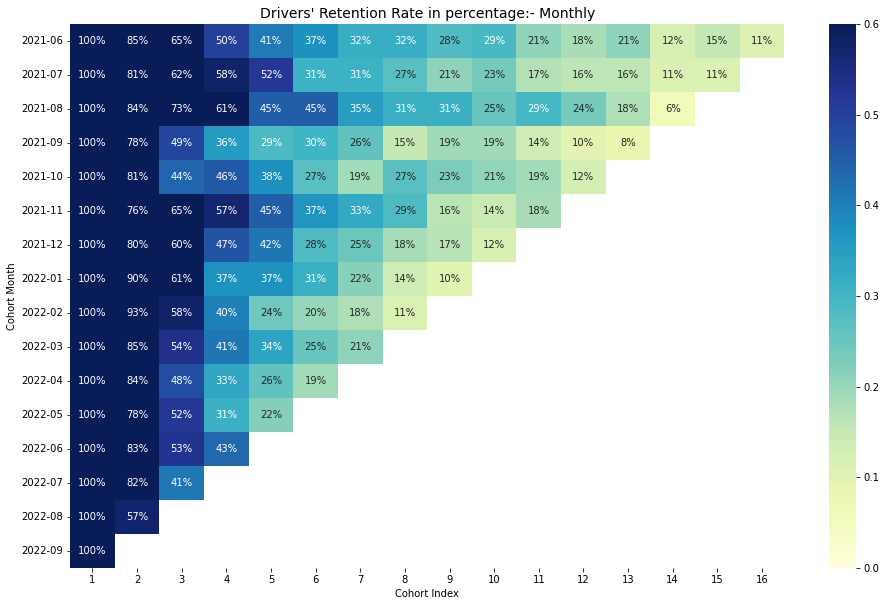

In [257]:
#### we filter on monthly clients and drivers with more than 10 trips(trials) 
df_cohort= df_combo[(df_combo["all_trips"]>10)].reset_index(drop=True)
grouping = df_cohort.groupby('driver_name')['month_year'] 
df_cohort['CohortMonth'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

transcation_year, transaction_month, _ = get_date_int(df_cohort, 'month_year')
cohort_year, cohort_month, _ = get_date_int(df_cohort, 'CohortMonth')
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
df_cohort['CohortIndex'] = years_diff * 12 + months_diff  + 1 
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['driver_name'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'driver_name')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
retention.index
plt.figure(figsize=(16, 10))
plt.title("Drivers' Retention Rate in percentage:- Monthly", fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

##### Slide8__(Cohort Drivers)(by gov map) (11 in pres)

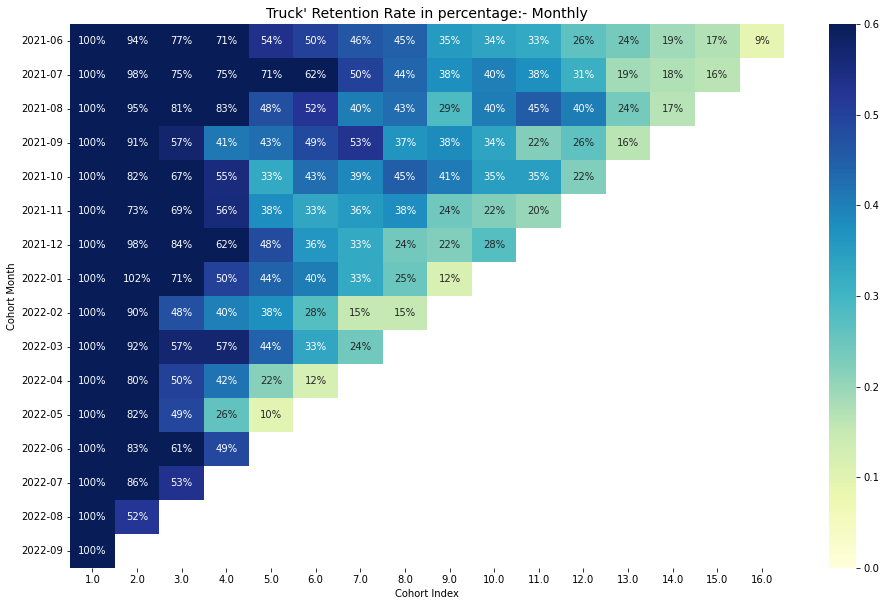

In [258]:
#### we filter on monthly clients and drivers with more than 10 trips(trials) 
df_cohort= df_combo[(df_combo["all_trips"]>10)].reset_index(drop=True)
grouping = df_cohort.groupby('plate_number')['month_year'] 
df_cohort['CohortMonth'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

transcation_year, transaction_month, _ = get_date_int(df_cohort, 'month_year')
cohort_year, cohort_month, _ = get_date_int(df_cohort, 'CohortMonth')
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
df_cohort['CohortIndex'] = years_diff * 12 + months_diff  + 1 
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['driver_name'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'driver_name')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
retention.index
plt.figure(figsize=(16, 10))
plt.title("Truck' Retention Rate in percentage:- Monthly", fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

#### Retail 

In [259]:
def retailer(val):
    val =  val.lower().replace('_'," ").replace("-"," ").replace('/'," ").split()
    if "تجزئة" in val:
        return "retail"
    else:
        return "non_retail"   

In [291]:
df2_retail = df.copy()
df2_retail= df2_retail.dropna(subset = ["dropoff_type"])

df2_retail.isnull().sum()
df2_retail = df2_retail.join(pd.get_dummies(df2_retail["truck"]))

df2_retail["retail"]= df2_retail["dropoff_type"].apply(retailer)


df2_retail_2 = pd.DataFrame(df2_retail.pivot_table(index="retail", 
                                              values=["id","supplier_name","driver_name", "manual_distance", "trip_duration", "dababa", "jumbo","trailer","van", "plate_number"], 
                                              aggfunc={"id": "count","driver_name":pd.Series.nunique,"supplier_name":pd.Series.nunique,"manual_distance":sum, "trip_duration":sum,
                                                       "dababa":sum, "jumbo":sum,"trailer":sum,"van":sum,
                                                       "plate_number":pd.Series.nunique}))
df2_retail_2 = df2_retail_2.reset_index()
df2_retail_2.columns = ["retail", "dababa_trips", "driver_count", "trip_count","jumbo_trips","distance", "truck_count","supplier_count", "trella_trips","duration","van_trips"]
df2_retail_2 = df2_retail_2.iloc[:,[0,2,6,3,1,4,8,10,5,9]]
df_sec= pd.DataFrame(df2_retail.groupby(["retail","truck"])["plate_number"].nunique()).unstack().reset_index()
df_sec.columns= [ "retail","dababa_count","jumbo_count","trella_count","van"]

df2_retail_2 =df2_retail_2.merge(df_sec)
df2_retail_2 = df2_retail_2.iloc[:,[0,1,2,3,10,4,11,5,12,6,13,7,8,9]]

##### Slide9__(retail duration and Kms ) (12 in pres)

duration


In [292]:
pd.DataFrame(df2_retail.groupby(["retail","id","truck"])["trip_duration"].mean()).reset_index().groupby(["retail","truck"])["trip_duration"].mean().unstack().fillna(0)#.to_csv("retail_duration.csv")

truck,dababa,jumbo,trailer,van
retail,,,,
non_retail,11.366879,10.209506,11.822507,0.941828
retail,9.823562,11.925152,39.000000,6.311905


distance

In [293]:
weird = df2_retail.copy()
# weird = weird.drop(index =50585)
weird = weird[weird["trips_status"]=='Completed']

In [294]:
weird["trips_status"].unique()

array(['Completed'], dtype=object)

In [295]:
weird.groupby("trucks")["manual_distance"].mean().reset_index()

,trucks,manual_distance
0,dababa,95.189762
1,jumbo,103.918455
2,trailer,118.172348
3,van,95.366184


In [296]:
weird.groupby(["retail","trucks"])["manual_distance"].mean().unstack().fillna(0)

trucks,dababa,jumbo,trailer,van
retail,,,,
non_retail,133.121263,101.957876,118.114521,63.846995
retail,88.038420,146.085470,700.000000,112.609865


##### Slide10__( unique drivers by contract type) (13 in pres)

In [22]:
df_t_2= df[["month_year","contract_type","driver_name"]].groupby(["month_year","contract_type"])["driver_name"].nunique().unstack().fillna(0).reset_index().drop(columns = ["Daily Rental"])#.to_csv("contract_type.csv")
df_t_2 = df_t_2.T
df_t_2.columns = cols[1:]
df_t_2 = df_t_2.iloc[1:,:]
df_t_2

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01
contract_type,,,,,,,,,,,,,,
Monthly,101.0,150.0,165.0,208.0,206.0,187.0,186.0,241.0,242.0,311.0,258.0,309.0,360.0,254.0
On_demand,172.0,184.0,188.0,142.0,161.0,260.0,309.0,244.0,226.0,381.0,438.0,276.0,271.0,85.0


##### Slide10__( trip counts by contract type) (14in pres)

In [23]:
df_t_2= df[["month_year","contract_type","driver_name"]].groupby(["month_year","contract_type"])["driver_name"].count().unstack().fillna(0).reset_index().drop(columns = ["Daily Rental"])#.to_csv("contract_type.csv")
df_t_2 = df_t_2.T
df_t_2.columns = cols[1:]
df_t_2 = df_t_2.iloc[1:,:]
df_t_2

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01
contract_type,,,,,,,,,,,,,,
Monthly,1240.0,1967.0,2423.0,3171.0,3097.0,2555.0,2679.0,3120.0,2967.0,4486.0,4228.0,4860.0,5011.0,1696.0
On_demand,818.0,1221.0,1755.0,2047.0,1902.0,2020.0,2070.0,1963.0,2272.0,1968.0,3025.0,2869.0,1335.0,143.0


# Driver RFM Model

In [229]:
driver_data = pd.DataFrame(df_combo.pivot_table(index="driver_name", 
                                              values=["trip_date","id", "manual_distance","month_year","monetary"], 
                                              aggfunc={"trip_date": [min, max, pd.Series.nunique],"id": "count","manual_distance":sum,"month_year":pd.Series.nunique,"monetary":"sum"}))

driver_data = driver_data.sort_values(by= [('id','count')], ascending = False).reset_index()
driver_data.columns = [ "driver_name","trip_count","distance","monetary","unique_months", "last_trip", "first_trip","unique_days"]
driver_data= driver_data.merge(df_combo.groupby(['driver_name'])['overnight_count'].sum().reset_index()[["driver_name","overnight_count"]],on = "driver_name")
driver_data["trip_count"]+=driver_data["overnight_count"]
driver_data= driver_data.drop(columns = "overnight_count" )
driver_data["first_trip"]= driver_data["first_trip"].astype("datetime64")
driver_data["last_trip"]=driver_data["last_trip"].astype("datetime64")
today_2022 = driver_data["last_trip"].max()
driver_data["lifetime"] = (today_2022 - driver_data["first_trip"]).dt.days
driver_data["recency"] = np.ceil((today_2022 - driver_data["last_trip"]).dt.days)
### Frequency here is the merge of the distance * trip_count
driver_data["frequency"]=driver_data["trip_count"]*driver_data["distance"]
driver_data["log_frequency"]= np.log(driver_data["frequency"])
driver_data["log_monetary"]= np.log(driver_data["monetary"])
driver_data["rel_frequency"] = np.round(driver_data["frequency"] / driver_data["unique_days"],2)
driver_data["rel_recency"] = np.round(1 - (driver_data["recency"] / driver_data["lifetime"]),2)
driver_data= driver_data.iloc[:,[0,1,2,4,5,6,7,8,3,10,9,11,12,13,14]]
driver_data= driver_data.replace([np.inf, -np.inf], np.nan)
driver_data = driver_data.fillna(0)
driver_data["trips/month"]=driver_data["trip_count"]/driver_data["unique_months"]


###############Emeira's Adjustments [condition excluding <10 trips (trials)] 
driver_data = driver_data[(driver_data["trip_count"]>10)].reset_index(drop=True)
driver_data

,driver_name,trip_count,distance,unique_months,last_trip,first_trip,unique_days,lifetime,monetary,frequency,recency,log_frequency,log_monetary,rel_frequency,rel_recency,trips/month
0,خالد خطاب محمد محمد,506.0,26992.0,14,2022-09-30,2021-07-07,329,450,99800,13657952.0,0.0,16.429832,11.510923,41513.53,1.00,36.142857
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,16,2022-09-29,2021-06-01,415,486,70950,24250237.0,1.0,17.003937,11.169731,58434.31,1.00,29.562500
2,ربيع شعبان عبدالمعطي ابوالعزم,432.0,33201.0,13,2022-06-30,2021-06-28,267,459,86200,14342832.0,92.0,16.478761,11.364425,53718.47,0.80,33.230769
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,16,2022-09-29,2021-06-01,409,486,61350,9237265.0,1.0,16.038756,11.024350,22585.00,1.00,25.562500
4,رضا صبحي رجب السيد,406.0,22108.0,16,2022-09-29,2021-06-01,406,486,60900,8975848.0,1.0,16.010048,11.016988,22108.00,1.00,25.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,أحمد رضا عبدالمنعم رشاد,11.0,602.0,4,2022-07-28,2021-12-16,6,288,1200,6622.0,64.0,8.798153,7.090077,1103.67,0.78,2.750000
1059,إسلام عربي السيد أحمد,11.0,435.0,4,2022-05-26,2021-11-25,6,309,1200,4785.0,127.0,8.473241,7.090077,797.50,0.59,2.750000
1060,خالد محمد شرشر محمد مصطفي,12.0,1431.0,3,2022-09-26,2022-06-18,6,104,2100,17172.0,4.0,9.751035,7.649693,2862.00,0.96,4.000000
1061,محمد عبدالله علي مصطفى,12.0,2470.0,1,2022-09-28,2022-09-05,6,25,2100,29640.0,2.0,10.296880,7.649693,4940.00,0.92,12.000000


In [230]:
### Needed functions
def maxer_m(df):
    max_index = []
    for i in df_combo.select_dtypes(include=["float"]).columns:
        max_index.append(df_combo[str(i)].idxmax())
    return pd.Series(max_index, name = "max_index")
def create_p(df,col,start,*args):
      p = []
      if start !=None:
        bins=[start]
      else:
        bins=[]
      cols= []
      c=0
      for i in list(args):
        p.append((c,"{}%".format(i) ,np.percentile(df[col], i)))
        bins.append(np.percentile(df[col], i))
        cols.append(np.percentile(df[col], i))
        c+=1
      p.append((c,"max", df[col].max()))
      bins.append(df[col].max())  
      cols.append(df[col].max())  
      print(p)
      return bins,cols

In [231]:
df_trucks_2= pd.DataFrame(pd.DataFrame(df_combo.groupby(["driver_name"]).count().reset_index()[df_combo.groupby(["driver_name"]).agg({"trucks":"nunique"}).reset_index()["trucks"]>1]["driver_name"]).reset_index(drop= True).merge(df_combo[["driver_name","trucks"]], on ="driver_name", how = "inner").groupby(["driver_name","trucks"])["trucks"].count()).unstack(level= 0).fillna(0).reset_index()
tcols = []
for i in df_trucks_2.columns:
    tcols.append(i[1])
df_trucks_2.columns = tcols
help=[""]  
for i in maxer_m(df_trucks_2):
    df_trucks_2 = df_trucks_2.transpose().reset_index()
    df_trucks_2 = df_trucks_2.join(pd.Series(help, name = "truck_type")).drop(index=[0]).reset_index(drop=True)[["index","truck_type"]]
    df_trucks_2.columns = ["driver_name","truck_type"]
    df_trucks_1= df_combo.groupby(["driver_name","trucks"]).count().reset_index()[["driver_name","trucks"]].drop_duplicates(subset=["driver_name"], keep='first').reset_index(drop= True)
    df_trucks= df_trucks_1.merge(df_trucks_2, on = "driver_name",how = "left").fillna(0)
for i in df_trucks["truck_type"].index.values:
    if df_trucks.loc[i]["truck_type"]!=0:
        df_trucks.loc[i]["trucks"]=df_trucks.loc[i]["truck_type"]
df_trucks[df_trucks["truck_type"]!=0]
driver_data = driver_data.merge(df_trucks[["driver_name","trucks"]],how = "left")
driver_data

,driver_name,trip_count,distance,unique_months,last_trip,first_trip,unique_days,lifetime,monetary,frequency,recency,log_frequency,log_monetary,rel_frequency,rel_recency,trips/month,trucks
0,خالد خطاب محمد محمد,506.0,26992.0,14,2022-09-30,2021-07-07,329,450,99800,13657952.0,0.0,16.429832,11.510923,41513.53,1.00,36.142857,jumbo
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,16,2022-09-29,2021-06-01,415,486,70950,24250237.0,1.0,17.003937,11.169731,58434.31,1.00,29.562500,dababa
2,ربيع شعبان عبدالمعطي ابوالعزم,432.0,33201.0,13,2022-06-30,2021-06-28,267,459,86200,14342832.0,92.0,16.478761,11.364425,53718.47,0.80,33.230769,jumbo
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,16,2022-09-29,2021-06-01,409,486,61350,9237265.0,1.0,16.038756,11.024350,22585.00,1.00,25.562500,dababa
4,رضا صبحي رجب السيد,406.0,22108.0,16,2022-09-29,2021-06-01,406,486,60900,8975848.0,1.0,16.010048,11.016988,22108.00,1.00,25.375000,dababa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,أحمد رضا عبدالمنعم رشاد,11.0,602.0,4,2022-07-28,2021-12-16,6,288,1200,6622.0,64.0,8.798153,7.090077,1103.67,0.78,2.750000,jumbo
1059,إسلام عربي السيد أحمد,11.0,435.0,4,2022-05-26,2021-11-25,6,309,1200,4785.0,127.0,8.473241,7.090077,797.50,0.59,2.750000,jumbo
1060,خالد محمد شرشر محمد مصطفي,12.0,1431.0,3,2022-09-26,2022-06-18,6,104,2100,17172.0,4.0,9.751035,7.649693,2862.00,0.96,4.000000,trailer
1061,محمد عبدالله علي مصطفى,12.0,2470.0,1,2022-09-28,2022-09-05,6,25,2100,29640.0,2.0,10.296880,7.649693,4940.00,0.92,12.000000,trailer


In [232]:
rfm = pd.DataFrame()
rfm['driver_name'] = driver_data.driver_name

recency

count    1063.000000
mean      142.795861
std       127.432766
min         0.000000
25%        30.000000
50%       114.000000
75%       218.000000
max       467.000000
Name: recency, dtype: float64
[(0, '33%', 58.460000000000036), (1, '66%', 173.0), (2, 'max', 467.0)]
[-1, 58.460000000000036, 173.0, 467.0]


,3,2,1
percentiles,58.46,173.0,467.0
count,356.00,356.0,351.0


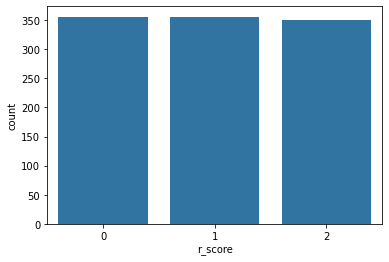

In [233]:
print(driver_data.recency.describe())
r_bins, r_cols = create_p(driver_data, "recency",-1,33,66)
print(r_bins)
rfm["r_score"] = pd.cut(driver_data["recency"], 
                                       bins=r_bins, 
                                       labels=[2,1,0],duplicates='drop').astype(int)
color = sns.color_palette()[0]
sns.countplot(rfm['r_score'], color = color)
dfr = rfm["r_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfr = dfr.append(pd.Series(r_cols), ignore_index = True)
dfr = dfr.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
#
dfr.columns = [3,2,1]
#
dfr

rel recency

In [234]:
# print(driver_data.rel_recency.describe())
# r_bins, r_cols = create_p(driver_data, "rel_recency",-1,20,40,60,80)
# print(r_bins)
# rfm["r_score"] = pd.cut(driver_data["rel_recency"], 
#                                        bins=r_bins, 
#                                        labels=[4,3,2,1,0],duplicates='drop').astype(int)
# color = sns.color_palette()[0]
# sns.countplot(rfm['r_score'], color = color)
# dfr = rfm["r_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
# dfr = dfr.append(pd.Series(r_cols), ignore_index = True)
# dfr = dfr.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
# #
# dfr.columns = [5,4,3,2,1]
# #
# dfr

frequency

count    1.063000e+03
mean     8.675149e+05
std      2.092622e+06
min      0.000000e+00
25%      3.273250e+04
50%      1.281600e+05
75%      6.299120e+05
max      2.425024e+07
Name: frequency, dtype: float64
[(0, '33%', 53483.82000000003), (1, '66%', 373364.4800000001), (2, 'max', 24250237.0)]
[-1, 53483.82000000003, 373364.4800000001, 24250237.0]


,1,2,3
percentiles,53483.82,373364.48,24250237.0
count,351.00,350.00,362.0


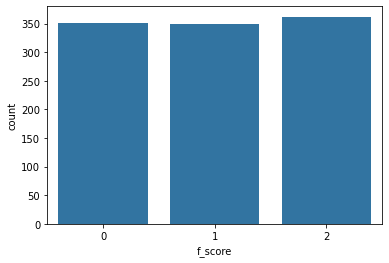

In [235]:
print(driver_data.frequency.describe())
f_bins, f_cols = create_p(driver_data, "frequency",-1,33,66)
print(f_bins)
#????
rfm["f_score"] = pd.cut(driver_data["frequency"], 
                                       bins=f_bins, 
                                       labels=[0,1,2])#.astype(int)
rfm["f_score"].value_counts()
sns.countplot(rfm['f_score'], color = color)
dfs = rfm["f_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfs = dfs.append(pd.Series(f_cols), ignore_index = True)
dfs = dfs.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
#
dfs.columns = [1,2,3]
dfs

log frequency

In [236]:
# print(driver_data.log_frequency.describe())
# f_bins, f_cols = create_p(driver_data, "log_frequency",-1,20,40,60,80)
# print(f_bins)
# #????
# rfm["f_score"] = pd.cut(driver_data["log_frequency"], 
#                                        bins=f_bins, 
#                                        labels=[0,1,2,3,4])#.astype(int)
# rfm["f_score"].value_counts()
# sns.countplot(rfm['f_score'], color = color)
# dfs = rfm["f_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
# dfs = dfs.append(pd.Series(f_cols), ignore_index = True)
# dfs = dfs.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
# #
# dfs.columns = [1,2,3,4,5]
# dfs

rel freqeuncy

In [237]:
# print(driver_data.rel_frequency.describe())
# f_bins, f_cols = create_p(driver_data, "rel_frequency",-1,20,40,60,80)
# print(f_bins)
# #????
# rfm["f_score"] = pd.cut(driver_data["rel_frequency"], 
#                                        bins=f_bins, 
#                                        labels=[0,1,2,3,4])#.astype(int)
# rfm["f_score"].value_counts()
# sns.countplot(rfm['f_score'], color = color)
# dfs = rfm["f_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
# dfs = dfs.append(pd.Series(f_cols), ignore_index = True)
# dfs = dfs.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
# #
# dfs.columns = [1,2,3,4,5]
# dfs

log monetary

In [238]:
# print(driver_data.log_monetary.describe())
# c_bins, c_cols = create_p(driver_data, "log_monetary",-1,20,40,60,80)
# c_bins
# #????
# rfm["m_score"] = pd.cut(driver_data["log_monetary"], 
#                                        bins=c_bins, 
#                                        labels=[0,1, 2, 3,4])#.astype("int")
# rfm["m_score"].value_counts()
# rfm["m_score"].value_counts()
# sns.countplot(rfm['m_score'], color = color)
# dfc = rfm["m_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
# dfc = dfc.append(pd.Series(c_cols), ignore_index = True)
# dfc = dfc.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
# dfc.columns = [1,2,3,4,5]
# dfc

monetary

count      1063.000000
mean      12500.376294
std       13424.070135
min        1200.000000
25%        3600.000000
50%        7400.000000
75%       16200.000000
max      101150.000000
Name: monetary, dtype: float64
[(0, '33%', 4600.0), (1, '66%', 12200.0), (2, 'max', 101150)]


,1,2,3
percentiles,4600.0,12200.0,101150.0
count,355.0,348.0,360.0


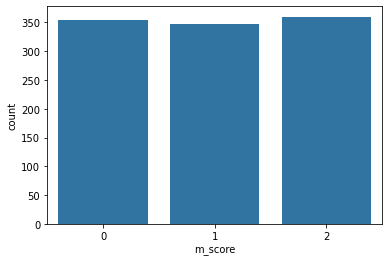

In [239]:
print(driver_data.monetary.describe())
c_bins, c_cols = create_p(driver_data, "monetary",-1,33,66)
c_bins
#????
rfm["m_score"] = pd.cut(driver_data["monetary"], 
                                       bins=c_bins, 
                                       labels=[0,1, 2])#.astype("int")
rfm["m_score"].value_counts()
rfm["m_score"].value_counts()
sns.countplot(rfm['m_score'], color = color)
dfc = rfm["m_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfc = dfc.append(pd.Series(c_cols), ignore_index = True)
dfc = dfc.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
dfc.columns = [1,2,3]
dfc

In [240]:
rfm["r_score"]= rfm["r_score"].astype("int")
rfm["f_score"]= rfm["f_score"].astype("int")
rfm["m_score"]= rfm["m_score"].astype("int")
rfm["RFM"] = rfm["r_score"] + rfm["f_score"]+rfm["m_score"] 
rfm["tier"]= rfm["RFM"].apply(lambda x : 3 if x <=2 else 2 if x<=4 else 1 )
print(rfm["RFM"].value_counts().sort_index().reset_index().transpose())
# print(rfm["RFM"].value_counts().reset_index().T)
rfm.to_csv("rfm.csv")
rfm

         0    1    2    3    4    5    6
index    0    1    2    3    4    5    6
RFM    126  146  184  159  170  139  139


,driver_name,r_score,f_score,m_score,RFM,tier
0,خالد خطاب محمد محمد,2,2,2,6,1
1,عبد الحافظ السيد عبدالحافظ السيد,2,2,2,6,1
2,ربيع شعبان عبدالمعطي ابوالعزم,1,2,2,5,1
3,قنديل مجدي قنديل عبدالعزيز,2,2,2,6,1
4,رضا صبحي رجب السيد,2,2,2,6,1
...,...,...,...,...,...,...
1058,أحمد رضا عبدالمنعم رشاد,1,0,0,1,3
1059,إسلام عربي السيد أحمد,1,0,0,1,3
1060,خالد محمد شرشر محمد مصطفي,2,0,0,2,3
1061,محمد عبدالله علي مصطفى,2,0,0,2,3


In [241]:
driver_data2 = driver_data.merge(rfm, on = "driver_name")
driver_data2

,driver_name,trip_count,distance,unique_months,last_trip,first_trip,unique_days,lifetime,monetary,frequency,recency,log_frequency,log_monetary,rel_frequency,rel_recency,trips/month,trucks,r_score,f_score,m_score,RFM,tier
0,خالد خطاب محمد محمد,506.0,26992.0,14,2022-09-30,2021-07-07,329,450,99800,13657952.0,0.0,16.429832,11.510923,41513.53,1.00,36.142857,jumbo,2,2,2,6,1
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,16,2022-09-29,2021-06-01,415,486,70950,24250237.0,1.0,17.003937,11.169731,58434.31,1.00,29.562500,dababa,2,2,2,6,1
2,ربيع شعبان عبدالمعطي ابوالعزم,432.0,33201.0,13,2022-06-30,2021-06-28,267,459,86200,14342832.0,92.0,16.478761,11.364425,53718.47,0.80,33.230769,jumbo,1,2,2,5,1
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,16,2022-09-29,2021-06-01,409,486,61350,9237265.0,1.0,16.038756,11.024350,22585.00,1.00,25.562500,dababa,2,2,2,6,1
4,رضا صبحي رجب السيد,406.0,22108.0,16,2022-09-29,2021-06-01,406,486,60900,8975848.0,1.0,16.010048,11.016988,22108.00,1.00,25.375000,dababa,2,2,2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,أحمد رضا عبدالمنعم رشاد,11.0,602.0,4,2022-07-28,2021-12-16,6,288,1200,6622.0,64.0,8.798153,7.090077,1103.67,0.78,2.750000,jumbo,1,0,0,1,3
1059,إسلام عربي السيد أحمد,11.0,435.0,4,2022-05-26,2021-11-25,6,309,1200,4785.0,127.0,8.473241,7.090077,797.50,0.59,2.750000,jumbo,1,0,0,1,3
1060,خالد محمد شرشر محمد مصطفي,12.0,1431.0,3,2022-09-26,2022-06-18,6,104,2100,17172.0,4.0,9.751035,7.649693,2862.00,0.96,4.000000,trailer,2,0,0,2,3
1061,محمد عبدالله علي مصطفى,12.0,2470.0,1,2022-09-28,2022-09-05,6,25,2100,29640.0,2.0,10.296880,7.649693,4940.00,0.92,12.000000,trailer,2,0,0,2,3


In [242]:
(driver_data2.groupby(["RFM"])["tier"].count()/driver_data2.shape[0]*100).reset_index().T

,0,1,2,3,4,5,6
RFM,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
tier,11.853246,13.734713,17.309501,14.957667,15.992474,13.076199,13.076199


In [243]:
(driver_data2.groupby(["tier"])["RFM"].count()/driver_data2.shape[0]*100).reset_index().T

,0,1,2
tier,1.000000,2.000000,3.00000
RFM,26.152399,30.950141,42.89746


Tier check

In [244]:
# check = driver_data2[driver_data2["tier"]==1]

# print("min: unique days: ", check["unique_days"].min()," "*15,"max: unique days: ", check["unique_days"].max())
# print("min: unique months: ",check["unique_months"].min()," "*15,"max: unique months: ",check["unique_months"].max())
# print("min: lifetime: ",check["lifetime"].min()," "*15,"max: lifetime: ",check["lifetime"].max())
# print("min: monetary: ", check["monetary"].min()," "*15,"max: monetary: ", check["monetary"].max())

---------------------------------------------------------------------------------------------------------------------------

##### Slide11__(rfm levels ) (16in pres)

In [245]:
(driver_data2.groupby(["tier"])["RFM"].count()/driver_data2.shape[0]*100).reset_index().T

,0,1,2
tier,1.000000,2.000000,3.00000
RFM,26.152399,30.950141,42.89746


In [246]:
driver_data2.groupby(["m_score"])["trips/month"].count()

m_score
0    355
1    348
2    360
Name: trips/month, dtype: int64

##### Slide12__(rfm levels ) (17in pres)

In [247]:
df_all = df_dstatus.merge(rfm[["driver_name","tier"]], on= "driver_name")
df_all.groupby(["tier"]).sum().iloc[:,4:-5].to_csv("trip_count_by_tier.csv")#.set_index(["tier1"])

##### Slide13__(rfm levels ) (18in pres)

In [248]:
df_all = df_combo.merge(rfm[["driver_name","tier"]], on= "driver_name")

In [249]:
df_all.groupby(["tier","month_year"])["manual_distance"].sum().unstack().fillna(0).to_csv("slide18.csv")

##### Slide14__(rfm levels ) (19in pres)

In [250]:
# df2_tiers.groupby(["month_year","tiers"]).agg({"trip_duration":sum}).unstack(level=0).iloc[3].reset_index().drop(columns="level_0").transpose()#.to_csv("pop.csv")
pop= df_all[df_all.tier==1].groupby(["month_year"]).agg({"trip_duration":np.mean,"trip_date":pd.Series.nunique}).reset_index()#.unstack(level=0).iloc[3].reset_index().drop(columns="level_0").transpose()#.to_csv("pop2.csv")
pop["trip_duration_per_day"]= round((pop["trip_duration"]*pop["trip_date"])/26,1)
pop["extra_dur_abs"]= round(pop["trip_duration_per_day"]-8,2)
pop["extra_dur_per"]= round(((pop["trip_duration_per_day"]/8)*100))
pop["extra_dur_per"]= pop["extra_dur_per"]/100

pop= pop[["month_year","extra_dur_per"]].T
pop.columns = cols[1:]
pop = pop.drop(index="month_year")
pop

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
extra_dur_per,1.35,1.48,1.59,1.55,1.7,1.6,1.81,1.79,1.65,1.8,1.62,1.59,1.52,1.61,1.6,1.54


##### Slide20__(finale)

In [251]:
driver_data2[driver_data2.tier==1]["trip_count"].sum()/driver_data2["trip_count"].sum()

0.5593731567376267

In [252]:
(driver_data2.groupby(["tier"])["trip_count"].sum())/driver_data2.groupby(["tier"])["RFM"].count()

tier
1    150.097122
2     67.252280
3     23.559211
dtype: float64

In [293]:
# driver_chSSeck = driver_data2.copy()
# driver_check["tier"] = driver_check["tier"].apply(lambda x: 1 if x ==3 else 3 if x ==1 else 2)

driver_data2[driver_data2["trucks"]=="dababa"].sort_values(by=["monetary","unique_days"],ascending= False)


,driver_name,trip_count,distance,unique_months,last_trip,first_trip,unique_days,lifetime,monetary,frequency,recency,log_frequency,log_monetary,rel_frequency,rel_recency,trips/month,trucks,r_score,f_score,m_score,RFM,tier,cohort
6,حسن اسماعيل حسين الحجار,396.0,27436.0,9,2022-02-03,2021-06-01,187,486,77100,10864656.0,239.0,16.201026,11.252859,58099.76,0.51,44.000000,dababa,0,2,2,4,2,4
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,16,2022-09-29,2021-06-01,415,486,70950,24250237.0,1.0,17.003937,11.169731,58434.31,1.00,29.562500,dababa,2,2,2,6,1,6
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,16,2022-09-29,2021-06-01,409,486,61350,9237265.0,1.0,16.038756,11.024350,22585.00,1.00,25.562500,dababa,2,2,2,6,1,6
4,رضا صبحي رجب السيد,406.0,22108.0,16,2022-09-29,2021-06-01,406,486,60900,8975848.0,1.0,16.010048,11.016988,22108.00,1.00,25.375000,dababa,2,2,2,6,1,6
5,ممدوح محمد عبدالعزيز,391.0,32072.0,15,2022-08-31,2021-06-01,391,486,58650,12540152.0,30.0,16.344446,10.979343,32072.00,0.94,26.066667,dababa,2,2,2,6,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,محمود صلاح الدين محمد,11.0,2172.0,2,2022-05-19,2022-03-04,11,210,1650,23892.0,134.0,10.081299,7.408531,2172.00,0.36,5.500000,dababa,1,0,0,1,3,1
1030,احمد محمد صابر ابوالمجد,11.0,995.0,2,2022-03-02,2022-02-19,11,223,1650,10945.0,212.0,9.300638,7.408531,995.00,0.05,5.500000,dababa,0,0,0,0,3,0
1031,نور الدين جمال,11.0,599.0,2,2021-08-16,2021-07-10,11,447,1650,6589.0,410.0,8.793157,7.408531,599.00,0.08,5.500000,dababa,0,0,0,0,3,0
1033,كريم صلاح حسين,11.0,1293.0,1,2021-08-14,2021-08-01,11,425,1650,14223.0,412.0,9.562616,7.408531,1293.00,0.03,11.000000,dababa,0,0,0,0,3,0
